# Huggingface with ART

In this notebook we will go over how to use the Huggingface AIP with ART. This can enable us to train robust foundation models which act over images. 

Currently this is a developing feature, and so not all ART tools are supported. Further tools and development is planned. As of ART 1.16 we support: 
+ Using a Pytorch backend.
+ Evasion attacks and defences on classical classification tasks such as image classification, but not tasks such as object detection.

If you have a use case that is not supported (or find a bug in this new feature!) please raise an issiue on ART.

Let's look at how we can use ART to secure Huggingface models!


In [1]:
# Relevant imports for the notebook

import transformers
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

import numpy as np
from torchvision import datasets
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# We will use CIFAR data for the notebook.
def get_cifar_data():
    """
    Get CIFAR-10 data.
    :return: cifar train/test data.
    """
    train_set = datasets.CIFAR10('./data', train=True, download=True)
    test_set = datasets.CIFAR10('./data', train=False, download=True)

    x_train = train_set.data.astype(np.float32)
    y_train = np.asarray(train_set.targets)

    x_test = test_set.data.astype(np.float32)
    y_test = np.asarray(test_set.targets)

    x_train = np.moveaxis(x_train, [3], [1])
    x_test = np.moveaxis(x_test, [3], [1])

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    return (x_train, y_train), (x_test, y_test)

In [3]:
def train_base_model(architecture='google/vit-base-patch16-224'):
    """
    Train a cifar classifier
    """

    (x_train, y_train), (x_test, y_test) = get_cifar_data()

    # Here we load a Huggingface model using the transformers library.
    model = transformers.AutoModelForImageClassification.from_pretrained(architecture,
                                                                         ignore_mismatched_sizes=True,
                                                                         num_labels=10)
    model = model.to(device)
    # The HuggingFaceClassifierPyTorch follows broadly the same API as the PyTorchClassifier
    # So we can supply the loss function, the input shape of the data we will supply, the optimizer, etc.
    # Note, frequently we will be performing fine-tuning or transfer learning with vision transformners and 
    # so we may be fine-tuning on differently sized inputs. 
    # The input_shape argument refers to the shape of the supplied input data which may be different to 
    # the shape required by the model. 
    # To handle this HuggingFaceClassifierPyTorch has an extra argument of processor which will act on 
    # every batch to process the data into the correct form required by the supplied model.
    # This needs to be manually specified by the user. For many attacks and defences to work it needs to be a 
    # differentiable funciton. 
    # Here the processor is a simple upsampler to enlarge the cifar images into the right size.
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')

    optimizer = Adam(model.parameters(), lr=1e-4)

    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(),
                                            optimizer=optimizer,
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            clip_values=(0, 1),
                                            processor=upsampler)

    hf_model.fit(x_train, y_train, nb_epochs=2)
    return hf_model

In [4]:
hf_base_model = train_base_model()
torch.save(hf_base_model.model.state_dict(), 'hf_base_model.pt')
del hf_base_model # Clear models we no longer need.

Files already downloaded and verified
Files already downloaded and verified


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def test_pgd(architecture, model_to_test='hf_base_model.pt'):
    """
    Here we can test the model we trained against a PGD attack.
    """
    
    import os
    from art.attacks.evasion import ProjectedGradientDescentPyTorch
    (x_train, y_train), (x_test, y_test) = get_cifar_data()
    model = transformers.AutoModelForImageClassification.from_pretrained(architecture,
                                                                         ignore_mismatched_sizes=True,
                                                                         num_labels=10)
    
    # Load the model state dict from the training loop we just performed.
    model.load_state_dict(torch.load(os.path.join('..', model_to_test)))
    optimizer = Adam(model.parameters(), lr=1e-4)

    # Set it up as a HuggingFaceClassifierPyTorch
    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(),
                                            optimizer=optimizer,
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            clip_values=(0, 1),
                                            processor=torch.nn.Upsample(scale_factor=7, mode='nearest'))

    # Let's just use 100 samples for quick demo purposes
    num_samples = 100
    outputs = hf_model.predict(x_test[:num_samples])
    acc = np.sum(np.argmax(outputs, axis=1) == y_test[:num_samples]) / len(y_test[:num_samples])
    print('clean acc ', acc)

    # The backend of the HuggingFaceClassifierPyTorch is the existing PyTorchClassifier. 
    # Thus we can interface HuggingFaceClassifierPyTorch with  aleadry existing attacks in ART which support pytorch.
    # Here we use ProjectedGradientDescentPyTorch.
    attacker = ProjectedGradientDescentPyTorch(hf_model, eps=8/255, eps_step=1/255)
    x_test_adv_robust = attacker.generate(x_test[:num_samples])
    outputs = hf_model.predict(x_test_adv_robust)
    acc = np.sum(np.argmax(outputs, axis=1) == y_test[:num_samples]) / len(y_test[:num_samples])
    print('adv acc ', acc)

    # We can display the adversarial examples to highlight the added perturbation to the original sample.
    x_test_adv_robust = np.moveaxis(x_test_adv_robust, [1], [3])
    x_test = np.moveaxis(x_test, [1], [3])

    delta = ((x_test[:num_samples] - x_test_adv_robust) + 8/255) * 10 # shift to have min 0 and make perturbations 10x larger to visualise them.

    fig, axs = plt.subplots(3, 3)
    for i in range(3):
        axs[i, 0].imshow(x_test_adv_robust[i])
        axs[i, 1].imshow(x_test[i])
        axs[i, 2].imshow(delta[i])
    plt.tight_layout()
    del hf_model # clear memory of unneeded models

Files already downloaded and verified
Files already downloaded and verified


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


clean acc  0.96


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adv acc  0.03


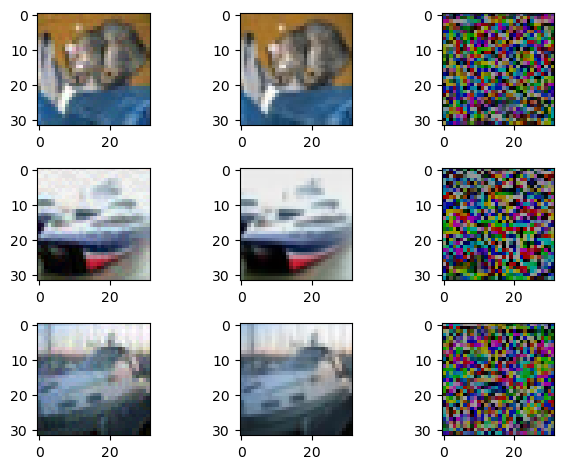

In [6]:
test_pgd(architecture='google/vit-base-patch16-224', model_to_test='hf_base_model.pt')

In [7]:
# We can see that we can attack the Huggingface transformer, so now let's use one of the defences in ART!

def adversarial_train():
    from art.defences.trainer import AdversarialTrainerMadryPGD
    (x_train, y_train), (x_test, y_test) = get_cifar_data()
    model = transformers.AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                                         ignore_mismatched_sizes=True,
                                                                         num_labels=10)

    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')

    optimizer = Adam(model.parameters(), lr=1e-4)

    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(), 
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            optimizer=optimizer,
                                            clip_values=(0, 1),
                                            processor=upsampler)

    # We can now use adversarial training with Madry's protocol.
    trainer = AdversarialTrainerMadryPGD(hf_model,
                                         nb_epochs=10,
                                         eps=8/255,
                                         eps_step=1/255,
                                         max_iter=10)

    trainer.fit(x_train, y_train)
    torch.save(trainer._classifier.model.state_dict(), 'hf_adv_model.pt')

In [8]:
# Uncomment the below to run the adverarial training, it can take some time depending on available hardware. 
# The expected runtime is around 15 hours using a Nvidia V100 GPU. More training could be conducted if better performance is desired.

# adversarial_train()

Files already downloaded and verified
Files already downloaded and verified


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


clean acc  0.88


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adv acc  0.43


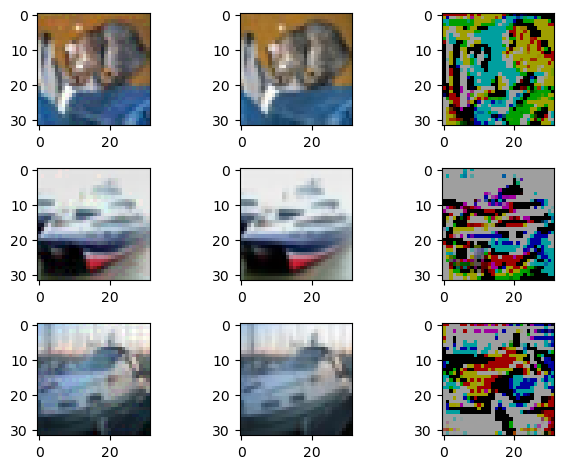

In [9]:
# We now test the adversariallty trained model and we can see we have done from 0% robustness to 43%.
test_pgd(architecture='google/vit-base-patch16-224', model_to_test='hf_adv_model.pt')

In [10]:
# We can also try with different models, for example here we try the functions with a different architecture

hf_base_model = train_base_model(architecture='microsoft/swin-tiny-patch4-window7-224')
torch.save(hf_base_model.model.state_dict(), 'swin_tiny_base_model.pt')
del hf_base_model

Files already downloaded and verified
Files already downloaded and verified


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Files already downloaded and verified
Files already downloaded and verified


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


clean acc  0.94


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adv acc  0.05


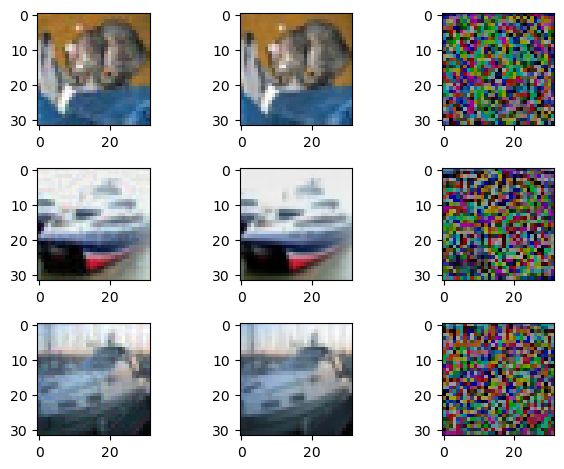

In [11]:
test_pgd(architecture='microsoft/swin-tiny-patch4-window7-224', model_to_test='./swin_tiny_base_model.pt')

In [12]:
# We can also try different architectures, for example one of the most popular models on Huggingface is the resn
def train_using_timm_model():
    import timm
    
    model = timm.create_model('resnet50.a1_in1k', pretrained=True)
    model = model.to(device)
    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
    
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(), 
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            optimizer=optimizer,
                                            clip_values=(0, 1),
                                            processor=upsampler)
    (x_train, y_train), (x_test, y_test) = get_cifar_data()
    hf_model.fit(x_train, y_train, nb_epochs=2)

    return hf_model

In [13]:
hf_timm_model = train_using_timm_model()
torch.save(hf_timm_model.model.state_dict(), 'timm_resnet_50.pt')
del hf_timm_model

Files already downloaded and verified
Files already downloaded and verified


In [14]:
def adversarial_train_timm():
    from art.defences.trainer import AdversarialTrainerMadryPGD
    import timm
    (x_train, y_train), (x_test, y_test) = get_cifar_data()

    model = timm.create_model('resnet50.a1_in1k', pretrained=True)

    upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')

    optimizer = Adam(model.parameters(), lr=1e-4)

    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(), 
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            optimizer=optimizer,
                                            clip_values=(0, 1),
                                            processor=upsampler)

    # We can now use adversarial training with Madry's protocol.
    trainer = AdversarialTrainerMadryPGD(hf_model,
                                         nb_epochs=10,
                                         eps=8/255,
                                         eps_step=1/255,
                                         max_iter=10)

    trainer.fit(x_train, y_train)
    torch.save(trainer._classifier.model.state_dict(), 'timm_resnet_50_adv_model.pt')

In [15]:
# Uncomment the below to run the adverarial training, it can take some time depending on available hardware. 
# The expected runtime is around 10 hours using a Nvidia V100 GPU. More training could be conducted if better performance is desired.

# adversarial_train_timm()

In [16]:
def test_on_pgd_timm():
    from art.attacks.evasion import ProjectedGradientDescentPyTorch
    import timm

    (x_train, y_train), (x_test, y_test) = get_cifar_data()
    
    model = timm.create_model('resnet50.a1_in1k', pretrained=True)

    model.load_state_dict(torch.load('timm_resnet_50_adv_model.pt'))
    loss_fn = torch.nn.CrossEntropyLoss()
    from torch.optim import Adam
    optimizer = Adam(model.parameters(), lr=1e-4)
    hf_model = HuggingFaceClassifierPyTorch(model, 
                                            loss=torch.nn.CrossEntropyLoss(),
                                            optimizer=optimizer,
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            clip_values=(0, 1),
                                            processor=torch.nn.Upsample(scale_factor=7, mode='nearest'))

    outputs = hf_model.predict(x_test[:100])
    acc = np.sum(np.argmax(outputs, axis=1) == y_test[:100]) / len(y_test[:100])
    print('clean acc ', acc)

    attacker = ProjectedGradientDescentPyTorch(hf_model, eps=8/255, eps_step=1/255)
    x_test_adv_robust = attacker.generate(x_test[:100])
    outputs = hf_model.predict(x_test_adv_robust)
    acc = np.sum(np.argmax(outputs, axis=1) == y_test[:100]) / len(y_test[:100])
    print('adv acc ', acc)

In [17]:
test_on_pgd_timm()

Files already downloaded and verified
Files already downloaded and verified
clean acc  0.69


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

adv acc  0.46


In [18]:
# We can also use the interface so supply custom Huggingface models. 
# Here is a simple example for running a toy neural network classifier.

import torch
from transformers.modeling_utils import PreTrainedModel
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import ImageClassifierOutput
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

class ModelConfig(PretrainedConfig):
    def __init__(
            self,
            **kwargs,
    ):
        super().__init__(**kwargs)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        self.conv = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fullyconnected = torch.nn.Linear(6272, 10)

    def forward(self, x):
        """
        Forward function to evaluate the model
        :param x: Input to the model
        :return: Prediction of the model
        """
        x = self.relu(self.conv(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 6272)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)

def train_simple_custom__model():
    config = ModelConfig()
    pt_model = Model(config=config)

    optimizer = torch.optim.Adam(pt_model.parameters(), lr=1e-3)
    
    simple_hf_classifier = HuggingFaceClassifierPyTorch(pt_model,
                                                         loss=torch.nn.CrossEntropyLoss(),
                                                         optimizer=optimizer,
                                                         input_shape=(3, 32, 32),
                                                         nb_classes=10,
                                                         clip_values=(0, 1),
                                                         processor=None) # No processor is needed as the data is of the correct size for the model.
    
    (x_train, y_train), (x_test, y_test) = get_cifar_data()
    simple_hf_classifier.fit(x_train, y_train, nb_epochs=20)

    num_samples = 100
    outputs = simple_hf_classifier.predict(x_test[:num_samples])
    acc = np.sum(np.argmax(outputs, axis=1) == y_test[:num_samples]) / len(y_test[:num_samples])
    print('clean acc ', acc)


In [19]:
train_simple_custom__model()

Files already downloaded and verified
Files already downloaded and verified
clean acc  0.65
